In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm, ttest_ind
from scipy.optimize import minimize_scalar

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import f_regression, mutual_info_regression, RFECV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

data2 = pd.read_csv('04_default_of_credit_card_clients.csv',sep=';') #Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.
data2.describe() #data description: see https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

class_names = [0,1] # for printing purposes later

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's choose the decision tree classifier 

[[8885  472]
 [1683  960]]


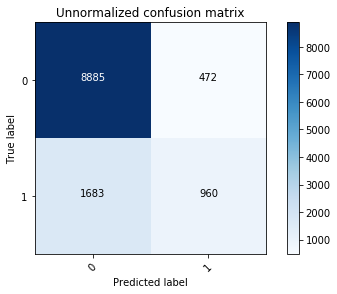

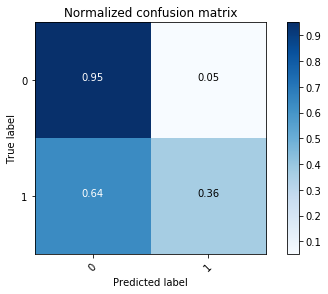

In [2]:

y = list(data2['class'])
X = data2.drop(['class'],axis=1)

clf = DecisionTreeClassifier(max_depth=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

y_pred = clf.fit(X_train,y_train).predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Unnormalized confusion matrix')
    
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
      
plt.show()

# Binning

X1 is the Amount of the given credit, it seems to be a good feature to bin.
The features from X12 to X23 seem to also be interesting feature to bin since they're represent the amount of bill statement and previous payments.

In [3]:

#labels = ["veryLow", "low", "average", "high", "veryHigh"]
data2_binned = data2
data2_binned["X1"] = pd.qcut(data2["X1"],5,labels=False)

for i in range(12,23):
    string = "X" + str(i)
    data2_binned[string]= pd.qcut(data2[string],5,labels=False, duplicates="drop")


pd.value_counts(data2_binned['X1'])


0    7676
2    6123
4    5958
3    5421
1    4822
Name: X1, dtype: int64

[[8882  475]
 [1674  969]]


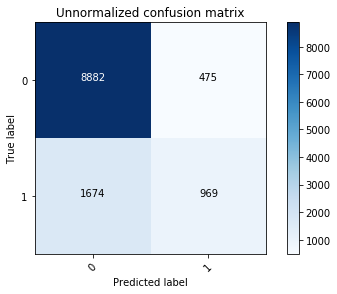

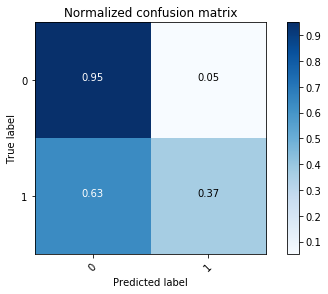

In [4]:

y = list(data2_binned['class'])
X = data2_binned.drop(['class'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

y_pred = clf.fit(X_train,y_train).predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Unnormalized confusion matrix')
    
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
      
plt.show()

Binning on X1 doen't change anything (only 10 examples change). 
We try to use binning on amount of bill statement and previous payments and again we get just a few more correct examples but that's all, it's not very effective.
I've tried with different values of bins and with 5 bins we obtain 63% of False Negative instead of 64%.

# Balancing

Problem: We have an instance of classification problem and our data set is imbalanced, that is, one class has significantly less representants than another class.

In [5]:
data2['class'].value_counts()

0    23364
1     6636
Name: class, dtype: int64

## Under sampling

Random under-sampling
Wall time: 30.5 ms
Counter({0: 6636, 1: 6636})


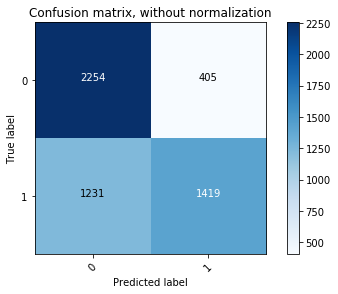

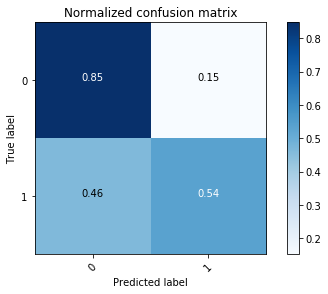

Tomek Links
Wall time: 2.1 s
Counter({0: 21623, 1: 6636})


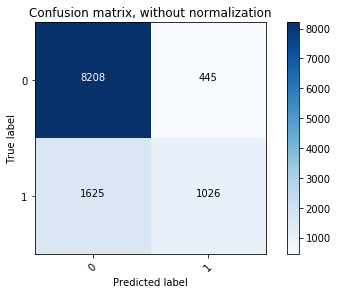

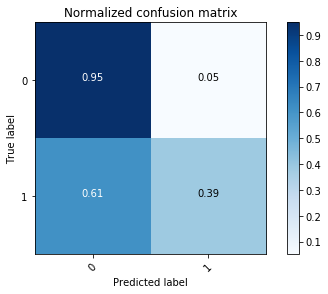

ENN
Wall time: 1.4 s
Counter({0: 13858, 1: 6636})


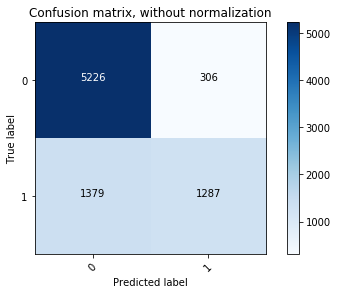

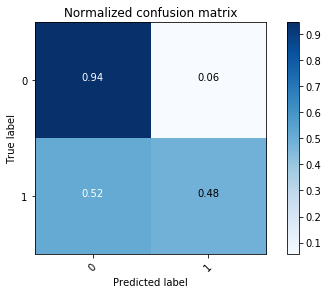

OSS
Wall time: 2.1 s
Counter({0: 21651, 1: 6636})


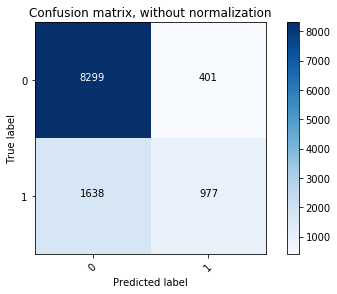

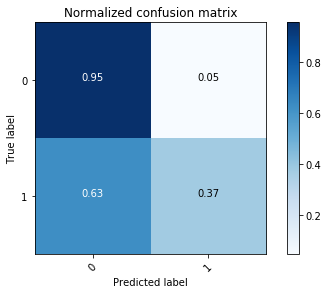

In [6]:
from collections import Counter

from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import OneSidedSelection 


y = list(data2['class'])
X = data2.drop(['class'],axis=1)

resamplers = [
    (RandomUnderSampler(random_state=42),'Random under-sampling'),
    (TomekLinks(random_state=42),'Tomek Links'),
    #(CondensedNearestNeighbour(random_state=42),'CNN'),
    (EditedNearestNeighbours(random_state=42),'ENN'),
    (OneSidedSelection(random_state=42),'OSS'), 
]

for resampler,description in resamplers:
    print(description)
    %time X_res, y_res = resampler.fit_sample(X, y)
    print(Counter(y_res))
    
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.4, random_state=42)
    
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    
    
    plt.show()



With all under samplings methods, we manage to decrease the error, but it's not very effective. Some almost doesn't change anything such as Tomek Links (5% of false positive - doesn't change, 64% of false negative to 62%), some decrease the rate of false negative but increase the rate of false positive such as random under-sampling (from 5% of FP to 15%, from 64% of FN to 46%).

## Over-sampling

SMOTE
Wall time: 335 ms
Counter({1: 23364, 0: 23364})


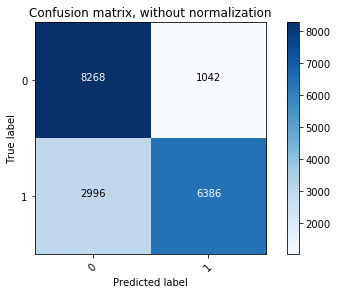

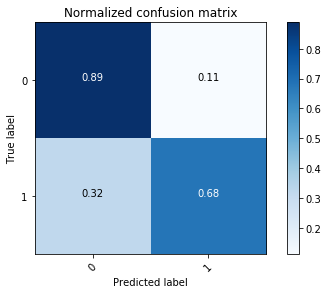

Random over-sampling
Wall time: 56 ms
Counter({1: 23364, 0: 23364})


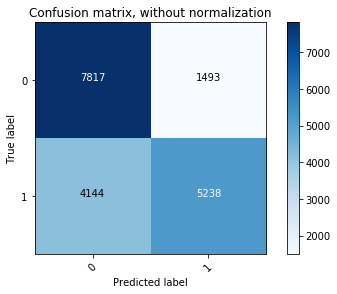

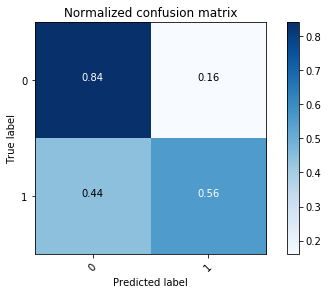

ADASYN
Wall time: 1.51 s
Counter({1: 23792, 0: 23364})


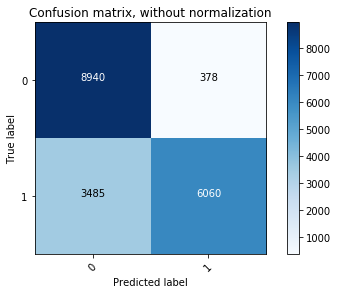

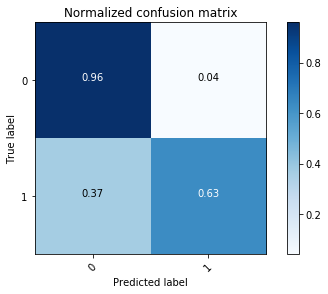

In [7]:
from collections import Counter


from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import ADASYN


y = list(data2['class'])
X = data2.drop(['class'],axis=1)

resamplers = [
    (SMOTE(random_state=42),'SMOTE'),
    (RandomOverSampler(random_state=42),'Random over-sampling'),
    (ADASYN(random_state=42),'ADASYN')
]

for resampler,description in resamplers:
    print(description)
    %time X_res, y_res = resampler.fit_sample(X, y)
    print(Counter(y_res))
    
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.4, random_state=42)
    
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    
    
    plt.show()



Over-sampling seems to get better results. Especially Smote technique which increase a little bit the rate of FP (from 5% to 11%) but decrease significantly the rate of FN (to 64% to 32%). Adasyn technique seems even better, it decrease the rate of FP from 5% to 4% and decrease the rate of  FN from 64% to 37%.

## Combination of over- and under-sampling methods

SMOTETomek
Wall time: 4.25 s
Counter({1: 22716, 0: 22716})


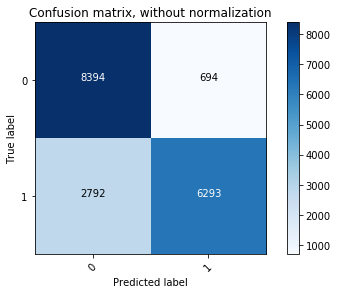

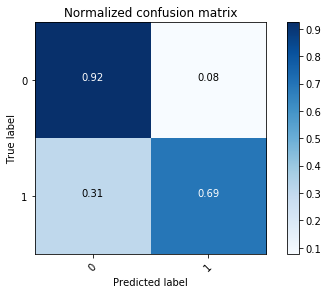

SMOTEENN
Wall time: 5.25 s
Counter({1: 17902, 0: 10469})


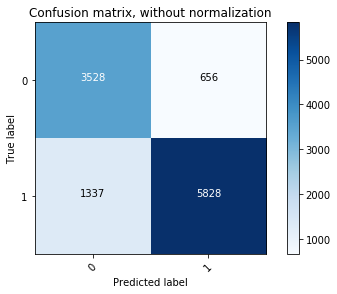

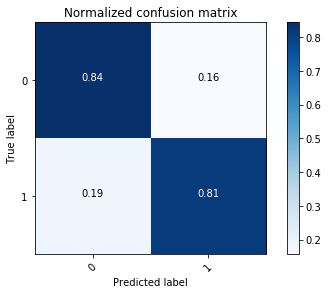

In [8]:
from collections import Counter


from imblearn.combine import SMOTETomek 
from imblearn.combine import SMOTEENN

y = list(data2['class'])
X = data2.drop(['class'],axis=1)


resamplers = [
    (SMOTETomek(random_state=42),'SMOTETomek'),
    (SMOTEENN(random_state=42),'SMOTEENN') 
]

for resampler,description in resamplers:
    print(description)
    %time X_res, y_res = resampler.fit_sample(X, y)
    print(Counter(y_res))
    
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.4, random_state=42)
    
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    
    
    plt.show()



The best way to decrease the error seems to use a combination of under-sampling and over-sampling such as SMOTETomek which combines Smote for over-sampling and Tomek Link for cleaning, or SMOTEENN which combines Smote for over-sampling and ENN for cleaning. We obtain slightly better results that if we just use over-sampling.

Let's try to use those two techniques with binning

In [9]:

data2_binned = data2
data2_binned["X1"] = pd.qcut(data2["X1"],10,labels=False,duplicates="drop")


for i in range(12,23):
    string = "X" + str(i)
    data2_binned[string]= pd.qcut(data2[string],10,labels=False, duplicates="drop")


SMOTETomek
Wall time: 4.72 s
Counter({1: 22751, 0: 22751})


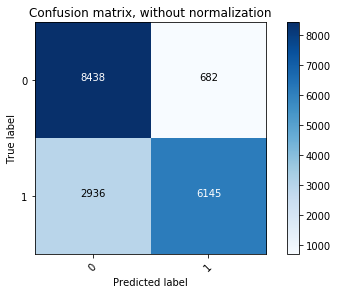

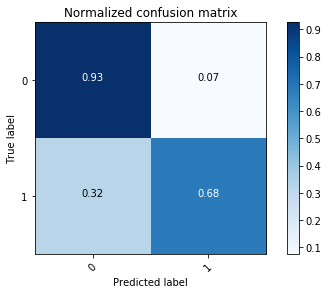

SMOTEENN
Wall time: 4.15 s
Counter({1: 17766, 0: 10452})


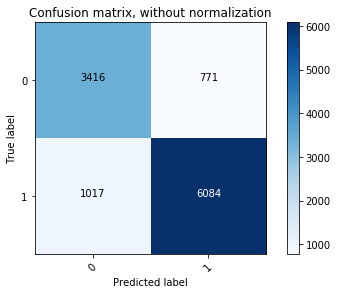

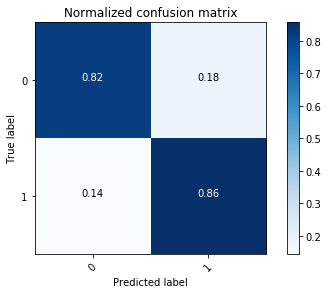

In [10]:
from collections import Counter


from imblearn.combine import SMOTETomek 
from imblearn.combine import SMOTEENN

y = list(data2_binned['class'])
X = data2_binned.drop(['class'],axis=1)


resamplers = [
    (SMOTETomek(random_state=42),'SMOTETomek'),
    (SMOTEENN(random_state=42),'SMOTEENN') 
]

for resampler,description in resamplers:
    print(description)
    %time X_res, y_res = resampler.fit_sample(X, y)
    print(Counter(y_res))
    
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.4, random_state=42)
    
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    
    
    plt.show()



We do not obtain better results

## Roc Curves

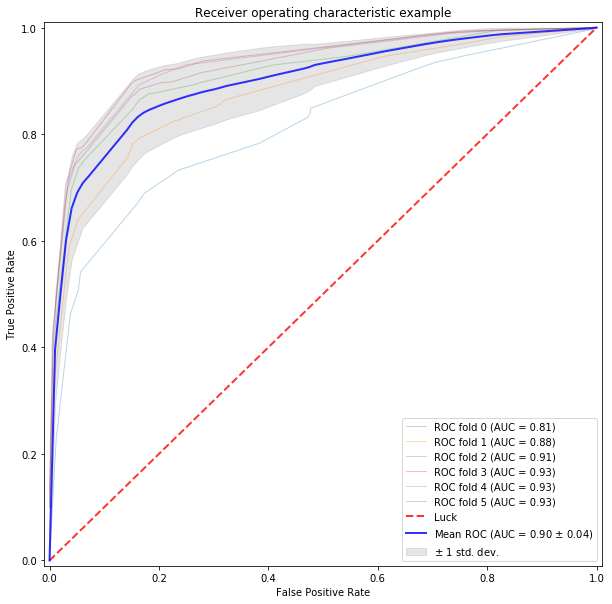

In [11]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold


y = list(data2['class'])
X = data2.drop(['class'],axis=1)

# We resample our data wit hthe SMOTEENN Technique
resampler = SMOTEENN(random_state=42)

X_res, y_res = resampler.fit_sample(X, y)

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))

i = 0
for train, test in cv.split(X_res, y_res):
    probas_ = clf.fit(X_res[train], y_res[train]).predict_proba(X_res[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_res[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


The average area under the curve is 90% which is pretty good, we should use the discrimination threshold of one of the Fold 3,4 or 5 because they give the best AUC.

## classification report based on metrics used with imbalanced dataset (umbalanced data)

In [12]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

from imblearn import over_sampling as os
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced

RANDOM_STATE = 42

pipeline = pl.make_pipeline(os.SMOTE(random_state=RANDOM_STATE),
                            DecisionTreeClassifier())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# Train the classifier with balancing
pipeline.fit(X_train, y_train)

# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_bal))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      0.79      0.42      0.81      0.55      0.31      5873
          1       0.36      0.42      0.79      0.39      0.55      0.29      1627

avg / total       0.73      0.71      0.50      0.72      0.55      0.31      7500



## classification report based on metrics used with imbalanced dataset (balanced data)

In [13]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=RANDOM_STATE)

# Train the classifier with balancing
pipeline.fit(X_train, y_train)

# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_bal))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.77      0.81      0.86      0.79      0.83      0.68      2616
          1       0.88      0.86      0.81      0.87      0.83      0.69      4439

avg / total       0.84      0.84      0.83      0.84      0.83      0.69      7055



We increase significantly all the the state-of-the-art metrics i.e. precision/recall/specificity, geometric mean, and index balanced accuracy of the geometric mean with the balanced data.

- The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
- The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
- The specificity is the ratio tn / (tn + fp) where tn is the number of true negatives and fn the number of false negatives. The specificity quantifies the ability to avoid false positives
- The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
- The geometric mean (G-mean) is the root of the product of class-wise sensitivity. This measure tries to maximize the accuracy on each of the classes while keeping these accuracies balanced. 
- Index of balanced accuracy : combines an unbiased index of its overall accuracy and a measure about how dominant is the class with the highest individual accuracy rate.
- The support is the number of occurrences of each class in y_true.


We tried different techniques to get better prediction results with our classifier (in this case, the decision tree). 
Binning didn't seem to be very effective on this dataset or maybe it's because of the chosen classifier.

Nevertheless, balancing techniques have been very useful, generally under and over-sampling decrease the error (e.g. the rate of false predictions) but the best results are obtained when we combine under and over-sampling, for example using Smote and Tomek links or ENN. We can clearly see that with the lasts reports computing the state-of-the-art metrucs just above.